In [84]:
import numpy as np
import pandas as pd

In [85]:
from PIL import Image

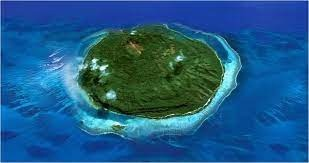

In [86]:
#Считаем картинку и положим значения rgb пикселей в массив numpy
img = Image.open('island.jpg')
arr = np.asarray(img, dtype='uint8')

In [87]:
arr[0][0]

array([181, 205, 255], dtype=uint8)

In [88]:
# Получили массив размером 309*163 каждый элемент которого является массивом из трех значений RGB
img.size

(309, 163)

In [89]:
# Считаем значения пикселей в список
pixels = []
for i in range(img.size[1]):
    for j in range(img.size[0]):
        pixels.append(arr[i][j])

In [90]:
pixels[:10]

[array([181, 205, 255], dtype=uint8),
 array([ 99, 123, 183], dtype=uint8),
 array([114, 138, 202], dtype=uint8),
 array([115, 138, 205], dtype=uint8),
 array([105, 129, 199], dtype=uint8),
 array([107, 131, 205], dtype=uint8),
 array([111, 134, 212], dtype=uint8),
 array([108, 131, 211], dtype=uint8),
 array([110, 135, 217], dtype=uint8),
 array([110, 135, 217], dtype=uint8)]

In [91]:
pixels = [arr.astype("int16") for arr in pixels]

In [92]:
# Преобразуем список в DataFrame для дальнейшей удобной работы с данными
# Длина df должна получиться 309*163, где каждая строка данных представляет собой значение цветов RGB
df = pd.DataFrame(data = pixels, columns = ['red', 'green', 'blue'])
df


,red,green,blue
0,181,205,255
1,99,123,183
2,114,138,202
3,115,138,205
4,105,129,199
...,...,...,...
50362,103,161,211
50363,102,156,200
50364,101,152,197
50365,94,146,186


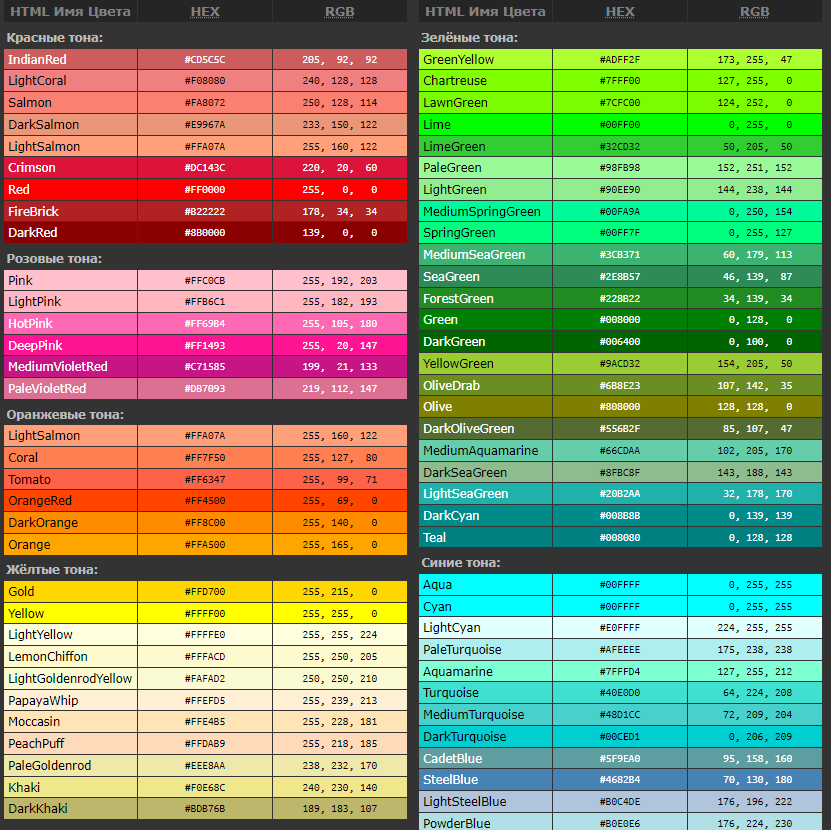

Посмотрев на таблицу цветов, замечаем, что оттенок цвета определяется максимальным значением его RGB модели. Т.е. условно если значения нашего пикселя составляют red=105 green=129 и blue=199, то мы имеем какой-то оттенок синего

In [93]:
# Определим максимальные значения в каждой из строк и запишем в новый столбец
df['dominant_color'] = df.idxmax(axis = 1)
df.head()

,red,green,blue,dominant_color
0,181,205,255,blue
1,99,123,183,blue
2,114,138,202,blue
3,115,138,205,blue
4,105,129,199,blue


In [94]:
# Видим что наша картинка довольно контрастная
df['dominant_color'].value_counts()

blue     39341
green    10968
red         58
Name: dominant_color, dtype: int64

In [95]:
#Попробуем рассчитать площадь разделив количество зеленых пикселей на все остальные
df['dominant_color'].value_counts()['green']/(df['dominant_color'].value_counts()['red']+
                                            df['dominant_color'].value_counts()['blue'])

0.27838270006852966

In [96]:
# Получили значение в 0,28 от всей картинки. Умножим на общее число пикселей(309*163)
round(0.27838270006852966*309*163)

14021

14021 пикселей составляет площадь нашего острова. Для точных значений в километрах нам нужны реальные масштабы картинки.
Попробуем оценить площадь острова в пикселях с помощью симмуляций.

In [97]:
from tqdm.notebook import tqdm

In [99]:
sample_size = [30, 100, 500, 1000, 5000, 10000, 50000, 100000, 1000000]
result = []

for n in tqdm(sample_size):
    simmulation = df['dominant_color'].sample(n , replace = True).value_counts()
    result.append(simmulation['green']/(simmulation.sum() - simmulation['green']))
    

  0%|          | 0/9 [00:00<?, ?it/s]

In [100]:
result

[0.36363636363636365,
 0.3157894736842105,
 0.24378109452736318,
 0.28205128205128205,
 0.26646403242147926,
 0.2729124236252546,
 0.2800491538875093,
 0.2755102040816326,
 0.27816761890154273]

In [101]:
[round(item * 50367) for item in result]

[18315, 15905, 12279, 14206, 13421, 13746, 14105, 13877, 14010]

In [103]:
df_simmulation = pd.Series(sample_size).to_frame().rename(columns = {0: 'sample_size'})
df_simmulation['square'] = pd.Series(result).values

In [104]:
df_simmulation

,sample_size,square
0,30,0.363636
1,100,0.315789
2,500,0.243781
3,1000,0.282051
4,5000,0.266464
5,10000,0.272912
6,50000,0.280049
7,100000,0.275510
8,1000000,0.278168


Выше мы посчитали площадь острова с разными подвыборками начиная от 30 до 1млн
Так как подвыборку мы брали всего по одному разу для каждого размера подвыборки, то на малых значениях
результаты варьируются от запуска к запуску, попробуем ссимулировать несколько подвыборок одинакого размера и взять среднее

In [111]:
sample_size = [30, 100, 500, 1000, 5000, 10000, 50000, 100000, 1000000]
mean_square = []

for n in tqdm(sample_size):
    tmp_squares = []
    simmulation = [df['dominant_color'].sample(n , replace = True).value_counts() for _ in range(3)]
    tmp_squares.append([value['green']/(value.sum() - value['green']) for value in simmulation])
    mean_square.append(np.mean(tmp_squares))

  0%|          | 0/9 [00:00<?, ?it/s]

In [112]:
mean_square

[0.35454545454545455,
 0.2612049197415051,
 0.29986382878139844,
 0.28807867283348904,
 0.2834072708859156,
 0.27569026444646894,
 0.2790153765615253,
 0.27948705530012696,
 0.2784793335621107]

Теперь наши значения площади не такие волатильные и при увелечении количества подвыборок мы можем получить довольно точный результат даже при сэмплировании в размере 30 значений

In [113]:
sample_size = [30, 100, 500, 1000, 5000, 10000, 50000, 100000, 1000000]
mean_square = []

for n in tqdm(sample_size):
    tmp_squares = []
    simmulation = [df['dominant_color'].sample(n , replace = True).value_counts() for _ in range(10)]
    tmp_squares.append([value['green']/(value.sum() - value['green']) for value in simmulation])
    mean_square.append(np.mean(tmp_squares))

  0%|          | 0/9 [00:00<?, ?it/s]

In [114]:
mean_square

[0.2615590930808322,
 0.2786519842862862,
 0.28566937053632124,
 0.28124461537928525,
 0.2794518247361713,
 0.27871601377724964,
 0.2798067872868025,
 0.27809712710656553,
 0.278166058042445]